## ⚠️ Proper Evaluation with Train/Test Split

In [1]:
# Proper train/test split evaluation
from matchmaker import MatchingEngine
import cudf
import numpy as np
from tqdm import tqdm

# 1. Load original data and split by timestamp
print("Loading original interaction data...")
raw_data = cudf.read_csv("data/swipes_clean.csv")

# Sort by timestamp and split 80/20
raw_data = raw_data.sort_values('timestamp')
split_idx = int(len(raw_data) * 0.8)

train_data = raw_data.iloc[:split_idx]
test_data = raw_data.iloc[split_idx:]

print(f"Train set: {len(train_data):,} interactions")
print(f"Test set:  {len(test_data):,} interactions")

# Save splits temporarily
train_data.to_csv("/tmp/train_split.csv", index=False)
test_data.to_csv("/tmp/test_split.csv", index=False)

# 2. Build a NEW engine on ONLY the training data
print("\n🔄 Training model on 80% of data...")
engine_test = MatchingEngine()
engine_test.load_interactions("/tmp/train_split.csv",
    decider_col='decidermemberid',
    other_col='othermemberid', 
    like_col='like', 
    timestamp_col='timestamp',
    gender_col='decidergender')
engine_test.run_engagement()
engine_test.run_popularity()
engine_test.build_recommender()

print("✅ Training complete on train set")

/home/zain/anaconda3/envs/matchmaker-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading original interaction data...
Train set: 7,862,310 interactions
Test set:  1,965,578 interactions

🔄 Training model on 80% of data...
Reading data... ✅
Constructing graph... ✅
Fitting ALS... 
🚀 Preparing data...
🎯 Training male→female ALS...


100%|██████████| 15/15 [00:00<00:00, 19.20it/s]


🎯 Training female→male ALS...


100%|██████████| 15/15 [00:00<00:00, 340.23it/s]


🔄 Converting factors to CuPy arrays...
✅ Trained M2F ALS with 31134 males × 32994 females
✅ Trained F2M ALS with 9925 females × 38446 males
Complete! ✅
User DF updated ✅
User DF updated ✅
Building FAISS recommender... ✅
✅ Training complete on train set


In [4]:
# 3. Evaluate on HELD-OUT test set
print("\n📊 Evaluating on held-out test set (20% of data)...\n")

# Get test set likes (ground truth)
test_likes_df = test_data[test_data['like'] == 1][['decidermemberid', 'othermemberid']].to_pandas()
test_likes = test_likes_df.groupby('decidermemberid')['othermemberid'].apply(list).to_dict()

# Get users who have likes in BOTH train and test (so we can recommend)
user_df_test = engine_test.user_df
test_users_sample = user_df_test[user_df_test.gender=='M'].dropna().sample(min(1000, len(user_df_test))).user_id.to_arrow().to_pylist()
test_users_valid = [u for u in test_users_sample if u in test_likes]

print(f"Test users with held-out likes: {len(test_users_valid)}")

if len(test_users_valid) == 0:
    print("⚠️ No test users found - need users who appear in both train and test sets")
else:
    # Generate recommendations using model trained on train set
    recs_batch = engine_test.recommend_batch(test_users_valid, k=100)
    
    hits = 0
    all_recs = []
    
    for user_id in tqdm(test_users_valid, desc="Evaluating"):
        # Extract user IDs from recommendations
        recs = [rec[0] for rec in recs_batch[user_id]]
        all_recs.extend(recs)
        
        # Check if any recommended users were actually liked IN THE TEST SET (unseen data)
        actual = set(test_likes[user_id])
        recommended = set(recs)
        
        if len(actual & recommended) > 0:
            hits += 1
    
    # Calculate metrics
    hit_rate = hits / len(test_users_valid)
    personalization = len(set(all_recs)) / len(all_recs) if len(all_recs) > 0 else 0
    
    print(f"\n{'='*70}")
    print("📊 HELD-OUT TEST SET EVALUATION (k=100)")
    print(f"{'='*70}")
    print(f"Hit Rate:        {hit_rate:.2%} ({hits}/{len(test_users_valid)} users)")
    print(f"Personalization: {personalization:.2%}")
    print(f"Unique recs:     {len(set(all_recs)):,}")
    print(f"{'='*70}")
    print("\n✅ This is the TRUE performance on unseen data!")


📊 Evaluating on held-out test set (20% of data)...

Test users with held-out likes: 559


Evaluating: 100%|██████████| 559/559 [00:00<00:00, 93829.68it/s]


📊 HELD-OUT TEST SET EVALUATION (k=100)
Hit Rate:        31.66% (177/559 users)
Personalization: 33.73%
Unique recs:     17,924

✅ This is the TRUE performance on unseen data!


📊 RECOMMENDATION COVERAGE ANALYSIS (Female Users)
Total female users available: 33,844
Females recommended at least once: 17,924
Females NEVER recommended: 15,920 (47.0%)



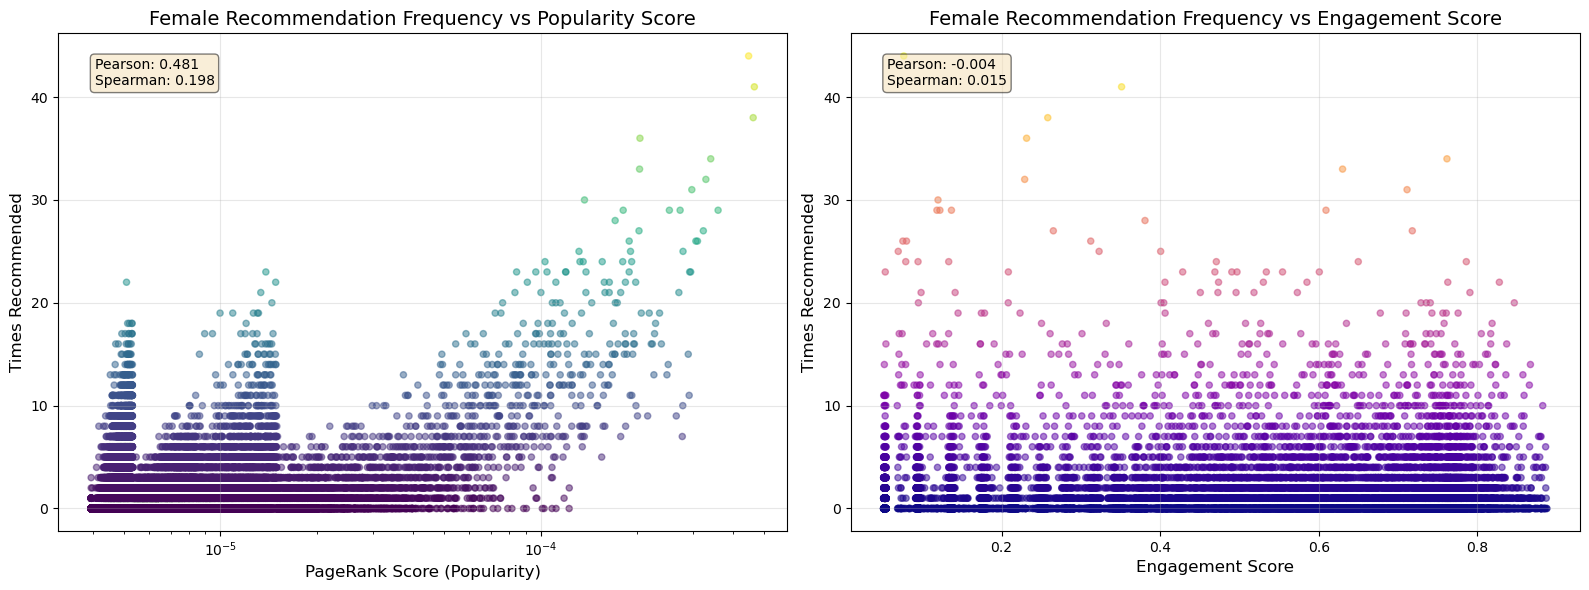


📉 NEVER-RECOMMENDED FEMALES ANALYSIS:
   • Avg PageRank: 0.000008 (vs 0.000010 overall)
   • Avg Engagement: 0.51 (vs 0.51 overall)
   • League distribution:
      - Bronze: 4981 (31.3%)
      - Silver: 3955 (24.8%)
      - Gold: 2757 (17.3%)
      - Platinum: 2481 (15.6%)
      - Diamond: 1217 (7.6%)

📊 COMPARISON: Recommended vs Never-Recommended Females

Metric                    Recommended          Never Recommended   
-----------------------------------------------------------------
Count                     17924                15920               
Avg PageRank              0.000012             0.000008            
Median PageRank           0.000007             0.000006            
Avg Engagement            0.52                 0.51                
Median Engagement         0.58                 0.57                


In [16]:
def analyse_recommendation_coverage(engine, all_recs, test_users_valid, gender='F'):
    """
    Analyse which users are being recommended and correlate with popularity/engagement.
    
    Parameters:
    -----------
    engine : MatchingEngine
        The trained recommendation engine
    all_recs : list
        All recommended user IDs from evaluation
    test_users_valid : list
        List of test users who received recommendations
    gender : str
        'F' - analyse females being recommended (to males)
        'M' - analyse males being recommended (to females)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from collections import Counter
    from scipy.stats import pearsonr, spearmanr
    
    # Get all potential candidates of specified gender
    user_df_test = engine.user_df
    candidates = user_df_test[user_df_test.gender == gender].copy().to_pandas()
    
    # Count how many times each candidate was recommended
    rec_counts_dict = Counter(all_recs)
    candidates['times_recommended'] = candidates['user_id'].map(lambda x: rec_counts_dict.get(x, 0))
    
    # Get candidates who were NEVER recommended
    never_recommended = candidates[candidates['times_recommended'] == 0]
    recommended_users = candidates[candidates['times_recommended'] > 0]
    
    gender_label = "Female" if gender == 'F' else "Male"
    
    print(f"📊 RECOMMENDATION COVERAGE ANALYSIS ({gender_label} Users)")
    print(f"{'='*70}")
    print(f"Total {gender_label.lower()} users available: {len(candidates):,}")
    print(f"{gender_label}s recommended at least once: {len(recommended_users):,}")
    print(f"{gender_label}s NEVER recommended: {len(never_recommended):,} ({len(never_recommended)/len(candidates)*100:.1f}%)")
    
    # Check if any users were actually recommended
    if len(recommended_users) == 0:
        print(f"\n⚠️  WARNING: No {gender_label.lower()}s were recommended in this evaluation!")
        print(f"   This is expected if you evaluated males recommending to females.")
        print(f"   Use gender='F' to analyse female recommendations (who males see).")
        return candidates, recommended_users, never_recommended
    
    print(f"{'='*70}\n")
    
    # Create scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Times Recommended vs PageRank (Popularity)
    axes[0].scatter(candidates['pagerank'], candidates['times_recommended'], 
                    alpha=0.5, s=20, c=candidates['times_recommended'], cmap='viridis')
    axes[0].set_xlabel('PageRank Score (Popularity)', fontsize=12)
    axes[0].set_ylabel('Times Recommended', fontsize=12)
    axes[0].set_title(f'{gender_label} Recommendation Frequency vs Popularity Score', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log')
    
    # Add correlation
    valid_mask = ~candidates['pagerank'].isna() & ~candidates['times_recommended'].isna()
    if valid_mask.sum() > 0:
        pearson_corr, _ = pearsonr(candidates[valid_mask]['pagerank'], 
                                    candidates[valid_mask]['times_recommended'])
        spearman_corr, _ = spearmanr(candidates[valid_mask]['pagerank'], 
                                      candidates[valid_mask]['times_recommended'])
        axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr:.3f}\nSpearman: {spearman_corr:.3f}', 
                    transform=axes[0].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. Times Recommended vs Engagement Score
    axes[1].scatter(candidates['engagement_score'], candidates['times_recommended'], 
                    alpha=0.5, s=20, c=candidates['times_recommended'], cmap='plasma')
    axes[1].set_xlabel('Engagement Score', fontsize=12)
    axes[1].set_ylabel('Times Recommended', fontsize=12)
    axes[1].set_title(f'{gender_label} Recommendation Frequency vs Engagement Score', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    # Add correlation
    valid_mask = ~candidates['engagement_score'].isna() & ~candidates['times_recommended'].isna()
    if valid_mask.sum() > 0:
        pearson_corr, _ = pearsonr(candidates[valid_mask]['engagement_score'], 
                                    candidates[valid_mask]['times_recommended'])
        spearman_corr, _ = spearmanr(candidates[valid_mask]['engagement_score'], 
                                      candidates[valid_mask]['times_recommended'])
        axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr:.3f}\nSpearman: {spearman_corr:.3f}', 
                    transform=axes[1].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(f'recommendation_coverage_{gender}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Detailed stats on never-recommended users
    if len(never_recommended) > 0:
        print(f"\n📉 NEVER-RECOMMENDED {gender_label.upper()}S ANALYSIS:")
        print(f"   • Avg PageRank: {never_recommended['pagerank'].mean():.6f} (vs {candidates['pagerank'].mean():.6f} overall)")
        print(f"   • Avg Engagement: {never_recommended['engagement_score'].mean():.2f} (vs {candidates['engagement_score'].mean():.2f} overall)")
        print(f"   • League distribution:")
        for league in ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']:
            count = len(never_recommended[never_recommended['league'] == league])
            pct = count / len(never_recommended) * 100 if len(never_recommended) > 0 else 0
            print(f"      - {league}: {count} ({pct:.1f}%)")
    
    # Compare recommended vs never-recommended users
    print(f"\n📊 COMPARISON: Recommended vs Never-Recommended {gender_label}s")
    print(f"{'='*70}")
    
    print(f"\n{'Metric':<25} {'Recommended':<20} {'Never Recommended':<20}")
    print(f"{'-'*65}")
    print(f"{'Count':<25} {len(recommended_users):<20} {len(never_recommended):<20}")
    print(f"{'Avg PageRank':<25} {recommended_users['pagerank'].mean():<20.6f} {never_recommended['pagerank'].mean():<20.6f}")
    print(f"{'Median PageRank':<25} {recommended_users['pagerank'].median():<20.6f} {never_recommended['pagerank'].median():<20.6f}")
    print(f"{'Avg Engagement':<25} {recommended_users['engagement_score'].mean():<20.2f} {never_recommended['engagement_score'].mean():<20.2f}")
    print(f"{'Median Engagement':<25} {recommended_users['engagement_score'].median():<20.2f} {never_recommended['engagement_score'].median():<20.2f}")

# Usage: Only analyse females (who are being recommended to males)
analyse_recommendation_coverage(engine_test, all_recs, test_users_valid, gender='F')

In [17]:
# 3. Evaluate on HELD-OUT test set
print("\n📊 Evaluating on held-out test set (20% of data)...\n")

# Get test set likes (ground truth)
test_likes_df = test_data[test_data['like'] == 1][['decidermemberid', 'othermemberid']].to_pandas()
test_likes = test_likes_df.groupby('decidermemberid')['othermemberid'].apply(list).to_dict()

# Get users who have likes in BOTH train and test (so we can recommend)
user_df_test = engine_test.user_df
test_users_sample = user_df_test[user_df_test.gender=='F'].dropna().sample(min(1000, len(user_df_test))).user_id.to_arrow().to_pylist()
test_users_valid = [u for u in test_users_sample if u in test_likes]

print(f"Test users with held-out likes: {len(test_users_valid)}")

if len(test_users_valid) == 0:
    print("⚠️ No test users found - need users who appear in both train and test sets")
else:
    # Generate recommendations using model trained on train set
    recs_batch = engine_test.recommend_batch(test_users_valid, k=100)
    
    hits = 0
    all_recs = []
    
    for user_id in tqdm(test_users_valid, desc="Evaluating"):
        # Extract user IDs from recommendations
        recs = [rec[0] for rec in recs_batch[user_id]]
        all_recs.extend(recs)
        
        # Check if any recommended users were actually liked IN THE TEST SET (unseen data)
        actual = set(test_likes[user_id])
        recommended = set(recs)
        
        if len(actual & recommended) > 0:
            hits += 1
    
    # Calculate metrics
    hit_rate = hits / len(test_users_valid)
    personalization = len(set(all_recs)) / len(all_recs) if len(all_recs) > 0 else 0
    
    print(f"\n{'='*70}")
    print("📊 HELD-OUT TEST SET EVALUATION (k=100)")
    print(f"{'='*70}")
    print(f"Hit Rate:        {hit_rate:.2%} ({hits}/{len(test_users_valid)} users)")
    print(f"Personalization: {personalization:.2%}")
    print(f"Unique recs:     {len(set(all_recs)):,}")
    print(f"{'='*70}")
    print("\n✅ This is the TRUE performance on unseen data!")


📊 Evaluating on held-out test set (20% of data)...

Test users with held-out likes: 309


Evaluating: 100%|██████████| 309/309 [00:00<00:00, 148051.17it/s]


📊 HELD-OUT TEST SET EVALUATION (k=100)
Hit Rate:        2.27% (7/309 users)
Personalization: 25.70%
Unique recs:     4,198

✅ This is the TRUE performance on unseen data!


In [ ]:
analyse_recommendation_coverage(engine_test, all_recs, test_users_valid, gender='M')

📊 RECOMMENDATION COVERAGE ANALYSIS (Male Users)
Total male users available: 135,192
Males recommended at least once: 4,198
Males NEVER recommended: 130,994 (96.9%)

